In [ ]:
!pip install transformers torch pandas numpy scikit-learn matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# 导入必要的库
import pandas as pd
import numpy as np
import torch
import os
import json
import random
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import re

# 设置随机种子，确保结果可复现
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 定义媒体权重映射
MEDIA_WEIGHTS = {
    "权威媒体": 1.5,
    "社交媒体": 0.8
}

# 定义情感关键词
positive_keywords = [
    '优秀', '良好', '出色', '杰出', '卓越', '优质', '优异', '优越', '优良', '优胜',
    '成功', '胜利', '突破', '创新', '进步', '发展', '提高', '增长', '增加', '改善',
    '繁荣', '富强', '强大', '强盛', '壮大', '蓬勃', '旺盛', '兴旺', '兴盛', '兴隆',
    '积极', '活跃', '热情', '热心', '热忱', '热烈', '热爱', '热衷', '热血', '热诚',
    '和谐', '和平', '和睦', '和美', '和善', '和顺', '和好', '和气', '和蔼', '和悦',
    '安全', '安心', '安宁', '安康', '安稳', '安逸', '安泰', '安详', '安乐', '安静',
    '幸福', '幸运', '幸甚', '幸好', '幸亏', '幸而', '幸喜', '幸赖', '幸免', '幸存',
    '协调', '统筹', '全面', '高质量', '平稳', '可持续', '共赢', '双赢', '创造性', '前瞻性',
    '示范', '示范性', '引领', '引导', '带动', '促进', '推动', '推进', '支持', '保障',
    '保证', '保护', '维护', '维稳', '稳定', '稳步', '稳健', '稳固', '稳妥', '实现'
]

negative_keywords = [
    '严重', '失败', '糟糕', '腐败', '负污', '违法', '犯罪', '事故',
    '灾害', '损失', '崩溃', '死亡', '危机', '恶劣', '打击', '修复',
    '政策失误', '执行不力', '形式主义', '官僚主义', '弄虚作假',
    '不作为', '乱作为', '谋政意识', '侵害群众利益', '安全隐患',
    '环境污染', '资源浪费', '生态被毁', '安全隐患', '违规操作',
    '质量问题', '监管不力', '失职渎职', '违纪违法', '腐败问题',
    '虚报冒领', '截留挪用', '贪污受贿', '权力寻租', '利益输送',
    '数据造假', '财务造假', '掩盖真相', '推卸责任', '效率低下',
    '双开', '被害', '受贿', '贪污', '违反', '开除'
]

# 创建情感关键词映射
sentiment_keywords = {}
for word in positive_keywords:
    sentiment_keywords[word] = 1  # 正面

for word in negative_keywords:
    sentiment_keywords[word] = -1  # 负面

使用设备: cuda


In [ ]:
# Google Colab上传数据的简化代码
def upload_data():
    """在Google Colab中上传TSV文件和news_data_csv压缩包"""
    from google.colab import files
    import os
    import zipfile

    # 上传TSV文件
    print("请上传news_dataset.tsv文件...")
    uploaded = files.upload()
    tsv_path = list(uploaded.keys())[0]  # 获取上传的第一个文件
    print(f"已上传文件: {tsv_path}")

    # 上传news_data_csv压缩包
    print("\n请上传news_data_csv.zip压缩包...")
    uploaded_zip = files.upload()
    zip_filename = list(uploaded_zip.keys())[0]  # 获取上传的第一个文件

    # 解压文件
    print(f"正在解压 {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('/content')

    # 设置CSV目录路径
    csv_directory = '/content/news_data_csv'
    print(f"数据已准备好: {csv_directory}")

    return tsv_path, csv_directory

# 在Google Colab环境中调用此函数
try:
    import google.colab
    IN_COLAB = True
    print("检测到Google Colab环境，请按照提示上传数据...")
    tsv_path, csv_directory = upload_data()
except:
    IN_COLAB = False
    # 本地环境中的路径设置
    tsv_path = "news_dataset.tsv"
    csv_directory = "news_data_csv"
    print("本地环境，使用预设路径")

检测到Google Colab环境，请按照提示上传数据...
请上传news_dataset.tsv文件...


Saving news_dataset.tsv to news_dataset.tsv
已上传文件: news_dataset.tsv

请上传news_data_csv.zip压缩包...


Saving news_data_csv.zip to news_data_csv.zip
正在解压 news_data_csv.zip...
数据已准备好: /content/news_data_csv


In [ ]:
# 数据准备函数
def prepare_data(tsv_path, csv_directory=None):
    """准备训练数据"""
    # 加载标注的TSV数据
    df = pd.read_csv(tsv_path, sep='\t')

    # 假设TSV数据有这些列: text, label (1:正面, 0:中性, -1:负面)
    # 如果TSV没有媒体类型，我们将从CSV文件的目录结构推断
    if 'source_type' not in df.columns and csv_directory:
        # 创建媒体类型映射
        media_type_map = {}

        # 检查quanwei目录（权威媒体）
        quanwei_dir = os.path.join(csv_directory, 'quanwei')
        if os.path.exists(quanwei_dir):
            for file in os.listdir(quanwei_dir):
                if file.endswith('.csv'):
                    media_type_map[file] = "权威媒体"

        # 检查shejiao目录（社交媒体）
        shejiao_dir = os.path.join(csv_directory, 'shejiao')
        if os.path.exists(shejiao_dir):
            for file in os.listdir(shejiao_dir):
                if file.endswith('.csv'):
                    media_type_map[file] = "社交媒体"

        # 从文件名推断媒体类型（假设TSV文件中有一列包含文件名或者可以关联）
        if 'source_file' in df.columns:
            df['source_type'] = df['source_file'].map(lambda x: media_type_map.get(x, "权威媒体"))
        else:
            # 如果没有关联列，默认为权威媒体
            df['source_type'] = "权威媒体"

    # 如果仍然没有source_type列，默认设为"权威媒体"
    if 'source_type' not in df.columns:
        df['source_type'] = "权威媒体"

    # 将source_type映射到权重
    df['media_weight'] = df['source_type'].map(lambda x: MEDIA_WEIGHTS.get(x, 1.0))

    return df

# 加载CSV新闻数据
def load_csv_news_data(csv_directory):
    """加载所有CSV新闻数据并添加媒体类型信息"""
    all_data = []

    # 处理权威媒体
    quanwei_dir = os.path.join(csv_directory, 'quanwei')
    if os.path.exists(quanwei_dir):
        for file in os.listdir(quanwei_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(quanwei_dir, file)
                try:
                    df = pd.read_csv(file_path, encoding='utf-8-sig')
                    df['source_type'] = "权威媒体"
                    df['source_file'] = file
                    all_data.append(df)
                except Exception as e:
                    print(f"读取文件 {file_path} 时出错: {e}")

    # 处理社交媒体
    shejiao_dir = os.path.join(csv_directory, 'shejiao')
    if os.path.exists(shejiao_dir):
        for file in os.listdir(shejiao_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(shejiao_dir, file)
                try:
                    df = pd.read_csv(file_path, encoding='utf-8-sig')
                    df['source_type'] = "社交媒体"
                    df['source_file'] = file
                    all_data.append(df)
                except Exception as e:
                    print(f"读取文件 {file_path} 时出错: {e}")

    # 合并所有数据
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"成功加载 {len(combined_df)} 条新闻数据")

        # 显示每种媒体类型的数量
        media_counts = combined_df['source_type'].value_counts()
        for media_type, count in media_counts.items():
            print(f"{media_type}: {count} 条")

        return combined_df
    else:
        print("未找到有效的CSV新闻数据")
        return None

In [ ]:
# 文本预处理函数
def preprocess_text(text):
    """预处理文本"""
    if not isinstance(text, str):
        return ""

    # 清除HTML标签和特殊字符
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)

    # 清除URL
    text = re.sub(r'https?://\S+', '', text)

    # 清除多余空白
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 使用关键词增强文本特征
def enhance_text_with_keywords(text):
    """使用关键词信息增强文本特征"""
    # 预处理文本
    processed_text = preprocess_text(text)

    # 查找文本中出现的关键词
    found_keywords = []

    # 查找正面关键词
    for word in positive_keywords:
        if word in processed_text:
            found_keywords.append(f"{word}_正面")

    # 查找负面关键词
    for word in negative_keywords:
        if word in processed_text:
            found_keywords.append(f"{word}_负面")

    # 如果找到关键词，将其添加到文本末尾
    if found_keywords:
        enhanced_text = processed_text + " " + " ".join(found_keywords)
        return enhanced_text

    return processed_text

# 创建数据集类
class NewsDataset(Dataset):
    def __init__(self, texts, labels, media_weights, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.media_weights = media_weights
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # 使用关键词增强文本
        text = enhance_text_with_keywords(text)

        # 使用BERT tokenizer处理文本
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 将编码后的数据转换为tensor
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            'media_weight': torch.tensor(self.media_weights[idx], dtype=torch.float)
        }

In [ ]:
# 使用关键词进行初步情感分析的函数
def get_initial_sentiment(text):
    """使用关键词为文本提供初步情感标签"""
    if not isinstance(text, str):
        return 0

    text = preprocess_text(text)

    pos_count = sum(1 for word in positive_keywords if word in text)
    neg_count = sum(1 for word in negative_keywords if word in text)

    # 设置阈值，确保情感明确
    if pos_count > neg_count + 1:  # 从+2降低到+1
        return 1  # 正面
    elif neg_count > pos_count + 1:  # 从+2降低到+1
        return -1  # 负面
    elif pos_count >= 3 and neg_count == 0:  # 添加新条件：至少3个正面词且无负面词
        return 1
    elif neg_count >= 3 and pos_count == 0:  # 添加新条件：至少3个负面词且无正面词
        return -1
    elif pos_count == neg_count and pos_count > 0:  # 当正负词数相等且不为0时
        # 随机选择一个标签，或根据上下文确定
        if len(text) > 100:  # 较长文本可能更倾向于客观报道
            return 0  # 中性
        else:
            return random.choice([-1, 0, 1])  # 随机选择
    else:
        return 0  # 中性或不确定

# 修改后的prepare_data函数，合并TSV和CSV数据
def prepare_data(tsv_path, csv_directory=None):
    """准备训练数据，合并TSV标注数据和CSV新闻数据"""
    # 加载TSV标注数据
    tsv_df = pd.read_csv(tsv_path, sep='\t')
    print(f"TSV标注数据: {len(tsv_df)}条")

    # 确保TSV数据有必要的列
    if 'text' not in tsv_df.columns or 'label' not in tsv_df.columns:
        raise ValueError("TSV文件必须包含'text'和'label'列")

    # 设置TSV数据的来源标记
    tsv_df['data_source'] = 'tsv'

    # 初始化CSV数据框
    csv_df = None

    # 如果提供了CSV目录，加载CSV新闻数据
    if csv_directory and os.path.exists(csv_directory):
        # 加载CSV新闻数据
        news_data = load_csv_news_data(csv_directory)

        if news_data is not None and len(news_data) > 0:
            # 只保留有内容的新闻
            news_data = news_data[news_data['content'].notna()]

            # 预处理：使用content作为text，创建伪标签
            csv_df = pd.DataFrame({
                'text': news_data['content'],
                'source_type': news_data['source_type'],
                'data_source': 'csv'
            })

            # 使用关键词为CSV数据创建初步标签
            csv_df['initial_label'] = csv_df['text'].apply(lambda x: get_initial_sentiment(x))

            # 只选择具有明确情感倾向的文本进行训练
            clear_sentiment_df = csv_df[csv_df['initial_label'] != 0].copy()
            clear_sentiment_df['label'] = clear_sentiment_df['initial_label']

            print(f"使用关键词标注的CSV数据: {len(clear_sentiment_df)}条")
            print(f"- 正面: {len(clear_sentiment_df[clear_sentiment_df['label'] == 1])}条")
            print(f"- 负面: {len(clear_sentiment_df[clear_sentiment_df['label'] == -1])}条")

            # 合并数据
            combined_df = pd.concat([tsv_df, clear_sentiment_df], ignore_index=True)
        else:
            combined_df = tsv_df
    else:
        combined_df = tsv_df

    # 设置媒体类型和权重
    if 'source_type' not in combined_df.columns:
        combined_df['source_type'] = "权威媒体"

    combined_df['media_weight'] = combined_df['source_type'].map(lambda x: MEDIA_WEIGHTS.get(x, 1.0))

    print(f"最终训练数据: {len(combined_df)}条")

    return combined_df

In [ ]:
# 训练函数
def train_model(model, train_dataloader, val_dataloader, epochs=4):
    # 定义优化器
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # 定义学习率调度器
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # 记录训练过程
    training_stats = []
    best_val_f1 = 0

    # 开始训练循环
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        # 训练阶段
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            # 将数据移到GPU/CPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 清除之前的梯度
            model.zero_grad()

            # 前向传播
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            # 反向传播
            loss.backward()

            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 更新参数
            optimizer.step()

            # 更新学习率
            scheduler.step()

        # 计算平均训练损失
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'平均训练损失: {avg_train_loss:.4f}')

        # 验证阶段
        model.eval()
        val_preds, val_true, val_weights = [], [], []
        total_val_loss = 0

        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            weights = batch['media_weight'].to(device)

            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            loss = outputs.loss
            total_val_loss += loss.item()

            # 获取预测结果
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())
            val_weights.extend(weights.cpu().numpy())

        # 计算平均验证损失
        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f'平均验证损失: {avg_val_loss:.4f}')

        # 计算验证指标
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_true, val_preds, average='weighted'
        )

        print(f'验证准确率: {val_accuracy:.4f}')
        print(f'验证F1分数: {val_f1:.4f}')

        # 保存最佳模型
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_sentiment_model.pt')
            print("保存最佳模型")

        # 记录统计信息
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1
        })

        print("\n")

    return training_stats

In [ ]:
# 预测函数
def predict_sentiment(model, tokenizer, texts, media_types=None, max_len=512):
    """预测文本情感"""
    model.eval()

    # 如果没有提供媒体类型，默认为权威媒体
    if media_types is None:
        media_types = ["权威媒体"] * len(texts)

    media_weights = [MEDIA_WEIGHTS.get(media_type, 1.0) for media_type in media_types]

    predictions = []
    scores = []  # 存储每个类别的概率
    weights = []

    for i, text in enumerate(texts):
        # 增强文本
        text = enhance_text_with_keywords(text)

        # 使用tokenizer处理文本
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 将编码后的数据移到设备上
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # 预测
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # 获取预测结果
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(logits, dim=1).item()

        # 将预测类别转换为情感值 (2->正面/1, 1->中性/0, 0->负面/-1)
        sentiment_value = pred_class - 1  # 将0,1,2映射到-1,0,1

        predictions.append(sentiment_value)
        scores.append(probs.cpu().numpy()[0])
        weights.append(media_weights[i])

    return predictions, scores, weights

# 计算整体情感得分
def calculate_overall_sentiment_score(predictions, weights):
    """计算整体情感得分
    情感得分 = 50 × (1 + (∑(新闻权重 × 情感值) / 总新闻数))
    """
    weighted_sum = sum(w * p for w, p in zip(weights, predictions))
    total_news = len(predictions)

    if total_news == 0:
        return 50.0

    score = 50 * (1 + weighted_sum / total_news)
    return round(score, 2)

# 保存完整模型和tokenizer
def save_model(model, tokenizer, output_dir):
    """保存完整的模型和tokenizer"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"保存模型和tokenizer到 {output_dir}")

    # 保存模型
    model.save_pretrained(output_dir)

    # 保存tokenizer
    tokenizer.save_pretrained(output_dir)

    # 保存配置信息
    config_info = {
        "media_weights": MEDIA_WEIGHTS,
        "model_type": "bert-base-chinese",
        "num_labels": 3,
        "label_map": {0: "负面", 1: "中性", 2: "正面"},
        "sentiment_map": {0: -1, 1: 0, 2: 1},
        "positive_keywords_count": len(positive_keywords),
        "negative_keywords_count": len(negative_keywords)
    }

    with open(os.path.join(output_dir, "config_info.json"), "w", encoding="utf-8") as f:
        json.dump(config_info, f, ensure_ascii=False, indent=4)

    print("模型保存完成")

# 加载完整模型
def load_full_model(model_dir):
    """加载完整的模型和配置"""
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"模型目录不存在: {model_dir}")

    # 加载tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_dir)

    # 加载模型
    model = BertForSequenceClassification.from_pretrained(model_dir)
    model.to(device)

    # 加载配置信息
    config_path = os.path.join(model_dir, "config_info.json")
    if os.path.exists(config_path):
        with open(config_path, "r", encoding="utf-8") as f:
            config_info = json.load(f)
        print("已加载模型配置信息")
    else:
        config_info = {
            "media_weights": MEDIA_WEIGHTS,
            "label_map": {0: "负面", 1: "中性", 2: "正面"},
            "sentiment_map": {0: -1, 1: 0, 2: 1}
        }
        print("未找到配置文件，使用默认配置")

    return model, tokenizer, config_info

In [ ]:
def main():


    # 加载BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

    # 加载CSV新闻数据
    news_data = load_csv_news_data(csv_directory)

    # 准备数据 - 使用修改后的函数，将TSV和CSV数据结合
    df = prepare_data(tsv_path, csv_directory)

    # 重新平衡数据集以确保各类别样本量相对平衡
    # 计算各类别样本数
    class_counts = df['label'].value_counts()
    print("各类别样本数:")
    print(class_counts)

    # 可以选择对数据进行重采样以平衡类别
    min_class_count = min(class_counts)
    balanced_dfs = []

    for label, count in class_counts.items():
        class_df = df[df['label'] == label]
        if count > min_class_count * 3:  # 如果某类数据过多，可以采样减少
            class_df = class_df.sample(min_class_count * 3, random_state=42)
        balanced_dfs.append(class_df)

    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    print(f"平衡后的数据集大小: {len(balanced_df)}")

    # 使用平衡后的数据集
    df = balanced_df

    # 划分训练集和验证集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    print(f"训练集大小: {len(train_df)}")
    print(f"验证集大小: {len(val_df)}")

    # 创建数据集
    train_dataset = NewsDataset(
        texts=train_df['text'].values,
        labels=train_df['label'].values + 1,  # 将-1,0,1映射到0,1,2
        media_weights=train_df['media_weight'].values,
        tokenizer=tokenizer
    )

    val_dataset = NewsDataset(
        texts=val_df['text'].values,
        labels=val_df['label'].values + 1,  # 将-1,0,1映射到0,1,2
        media_weights=val_df['media_weight'].values,
        tokenizer=tokenizer
    )

    # 创建数据加载器
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=16
    )

    # 加载预训练BERT模型并增加dropout防止过拟合
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-chinese',
        num_labels=3  # 3个标签：负面(0)、中性(1)、正面(2)
    ).to(device)

    # 将模型的dropout设置得更高以防止过拟合
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0.45  # 增加dropout率

    # 训练模型
    training_stats = train_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        epochs=5  # 可以根据需要调整
    )

    # 加载最佳模型
    model.load_state_dict(torch.load('best_sentiment_model.pt'))

    # 在验证集上进行最终评估
    val_texts = val_df['text'].values
    val_labels = val_df['label'].values  # 原始标签：-1(负面), 0(中性), 1(正面)
    val_media_types = val_df['source_type'].values

    predictions, scores, weights = predict_sentiment(
        model, tokenizer, val_texts, val_media_types
    )

    # 计算评估指标
    accuracy = accuracy_score(val_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels, predictions, average='weighted'
    )

    print("\n最终评估结果:")
    print(f"准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

    # 打印详细分类报告
    print("\n分类报告:")
    target_names = ['负面', '中性', '正面']
    print(classification_report(val_labels, predictions, target_names=target_names))

    # 可视化训练过程
    stats_df = pd.DataFrame(training_stats)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(stats_df['epoch'], stats_df['train_loss'], label='训练损失')
    plt.plot(stats_df['epoch'], stats_df['val_loss'], label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证损失')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(stats_df['epoch'], stats_df['val_accuracy'], label='准确率')
    plt.plot(stats_df['epoch'], stats_df['val_f1'], label='F1分数')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('验证指标')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    # 保存完整模型
    model_save_dir = "/content/news_sentiment_model" if IN_COLAB else "news_sentiment_model"
    save_model(model, tokenizer, model_save_dir)
    print(f"完整模型已保存到: {model_save_dir}")

    # 在Google Colab中备份模型到Drive
    if IN_COLAB:
        try:
            from google.colab import drive

            # 如果尚未挂载Drive，先挂载
            if not os.path.exists('/content/drive'):
                print("挂载Google Drive...")
                drive.mount('/content/drive')

            # 创建保存目录
            drive_save_path = "/content/drive/MyDrive/news_sentiment_model"
            if not os.path.exists(drive_save_path):
                os.makedirs(drive_save_path)

            # 复制模型文件到Drive
            import shutil
            for item in os.listdir(model_save_dir):
                src_path = os.path.join(model_save_dir, item)
                dst_path = os.path.join(drive_save_path, item)
                if os.path.isfile(src_path):
                    shutil.copy2(src_path, dst_path)
                elif os.path.isdir(src_path):
                    if os.path.exists(dst_path):
                        shutil.rmtree(dst_path)
                    shutil.copytree(src_path, dst_path)

            print(f"模型已备份到Google Drive: {drive_save_path}")

        except Exception as e:
            print(f"保存到Google Drive时出错: {str(e)}")

    # 如果有新闻数据，进行情感分析
    if news_data is not None:
        print("\n对CSV新闻数据进行情感分析...")

        # 只选择有内容的新闻
        news_df = news_data[news_data['content'].notna()]

        # 进行预测
        news_texts = news_df['content'].values
        news_media_types = news_df['source_type'].values

        news_predictions, news_scores, news_weights = predict_sentiment(
            model, tokenizer, news_texts, news_media_types
        )

        # 添加预测结果到数据
        news_df['sentiment_pred'] = news_predictions
        news_df['sentiment_label'] = news_df['sentiment_pred'].map({-1: '负面', 0: '中性', 1: '正面'})

        # 计算情感分布
        sentiment_counts = {}
        for sentiment_value, weight in zip(news_predictions, news_weights):
            if sentiment_value == 1:
                key = '正面'
            elif sentiment_value == 0:
                key = '中性'
            else:  # -1
                key = '负面'

            if key not in sentiment_counts:
                sentiment_counts[key] = {
                    'count': 0,
                    'weighted_count': 0
                }

            sentiment_counts[key]['count'] += 1
            sentiment_counts[key]['weighted_count'] += weight

        total_count = len(news_predictions)
        total_weighted_count = sum(news_weights)

        print("\n情感分布:")
        for sentiment, data in sentiment_counts.items():
            count = data['count']
            weighted_count = data['weighted_count']
            percentage = count / total_count * 100
            weighted_percentage = weighted_count / total_weighted_count * 100

            print(f"{sentiment}: {count} ({percentage:.1f}%), 加权: {weighted_count:.1f} ({weighted_percentage:.1f}%)")

        # 计算每个媒体类型的情感分布
        for media_type in set(news_media_types):
            indices = [i for i, mt in enumerate(news_media_types) if mt == media_type]
            if not indices:
                continue

            media_preds = [news_predictions[i] for i in indices]
            media_weights = [news_weights[i] for i in indices]

            media_sentiment_counts = {}
            for sentiment_value, weight in zip(media_preds, media_weights):
                if sentiment_value == 1:
                    key = '正面'
                elif sentiment_value == 0:
                    key = '中性'
                else:  # -1
                    key = '负面'

                if key not in media_sentiment_counts:
                    media_sentiment_counts[key] = {
                        'count': 0,
                        'weighted_count': 0
                    }

                media_sentiment_counts[key]['count'] += 1
                media_sentiment_counts[key]['weighted_count'] += weight

            media_total_count = len(media_preds)
            media_total_weighted_count = sum(media_weights)

            print(f"\n{media_type} 情感分布:")
            for sentiment, data in media_sentiment_counts.items():
                count = data['count']
                weighted_count = data['weighted_count']
                percentage = count / media_total_count * 100
                weighted_percentage = weighted_count / media_total_weighted_count * 100

                print(f"{sentiment}: {count} ({percentage:.1f}%), 加权: {weighted_count:.1f} ({weighted_percentage:.1f}%)")

        # 计算总体情感得分
        overall_score = calculate_overall_sentiment_score(news_predictions, news_weights)
        print(f"\n总体情感得分: {overall_score:.2f}")

        # 保存预测结果
        result_path = "/content/news_with_sentiment.csv" if IN_COLAB else "news_with_sentiment.csv"
        news_df.to_csv(result_path, index=False, encoding='utf-8-sig')
        print(f"新闻情感分析结果已保存到: {result_path}")

成功加载 27754 条新闻数据
社交媒体: 23218 条
权威媒体: 4536 条
TSV标注数据: 2000条
成功加载 27754 条新闻数据
社交媒体: 23218 条
权威媒体: 4536 条
使用关键词标注的CSV数据: 16221条
- 正面: 15587条
- 负面: 634条
最终训练数据: 18221条
各类别样本数:
label
 1    16587
-1     1034
 0      600
Name: count, dtype: int64
平衡后的数据集大小: 3434
训练集大小: 2747
验证集大小: 687


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
----------
平均训练损失: 0.4090
平均验证损失: 0.1159
验证准确率: 0.9607
验证F1分数: 0.9610
保存最佳模型


Epoch 2/5
----------
平均训练损失: 0.1153
平均验证损失: 0.1879
验证准确率: 0.9403
验证F1分数: 0.9412


Epoch 3/5
----------
平均训练损失: 0.0829
平均验证损失: 0.1641
验证准确率: 0.9432
验证F1分数: 0.9441


Epoch 4/5
----------
平均训练损失: 0.0680
平均验证损失: 0.1446
验证准确率: 0.9505
验证F1分数: 0.9512


Epoch 5/5
----------
平均训练损失: 0.0603
平均验证损失: 0.1964
验证准确率: 0.9447
验证F1分数: 0.9455



最终评估结果:
准确率: 0.9607
精确率: 0.9624
召回率: 0.9607
F1分数: 0.9610

分类报告:
              precision    recall  f1-score   support

          负面       0.91      0.97      0.94       209
          中性       1.00      1.00      1.00       102
          正面       0.98      0.94      0.96       376

    accuracy                           0.96       687
   macro avg       0.96      0.97      0.97       687
weighted avg       0.96      0.96      0.96       687



<ipython-input-20-09079714712d>:137: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-09079714712d>:137: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-09079714712d>:137: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-09079714712d>:137: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-09079714712d>:137: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-09079714712d>:137: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-20-09079714712d>:137: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missi

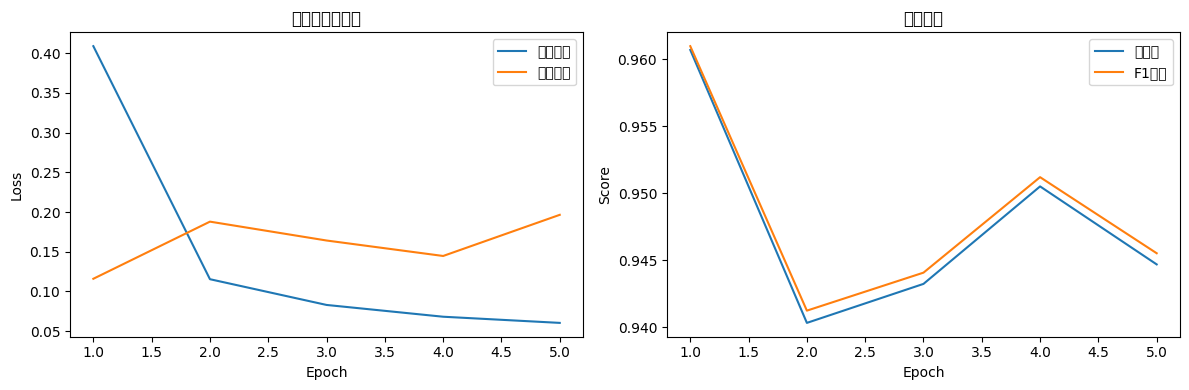

保存模型和tokenizer到 /content/news_sentiment_model
模型保存完成
完整模型已保存到: /content/news_sentiment_model
模型已备份到Google Drive: /content/drive/MyDrive/news_sentiment_model

对CSV新闻数据进行情感分析...

情感分布:
正面: 23768 (85.6%), 加权: 21967.0 (86.6%)
负面: 2299 (8.3%), 加权: 2040.1 (8.0%)
中性: 1687 (6.1%), 加权: 1371.3 (5.4%)

权威媒体 情感分布:
正面: 4218 (93.0%), 加权: 6327.0 (93.0%)
负面: 287 (6.3%), 加权: 430.5 (6.3%)
中性: 31 (0.7%), 加权: 46.5 (0.7%)

社交媒体 情感分布:
正面: 19550 (84.2%), 加权: 15640.0 (84.2%)
负面: 2012 (8.7%), 加权: 1609.6 (8.7%)
中性: 1656 (7.1%), 加权: 1324.8 (7.1%)

总体情感得分: 85.90
新闻情感分析结果已保存到: /content/news_with_sentiment.csv


In [ ]:
# 使用训练好的模型进行预测的示例代码
def use_saved_model(model_dir, input_texts, media_types=None):
    """使用保存的模型进行预测"""
    # 加载模型和配置
    model, tokenizer, config_info = load_full_model(model_dir)

    # 获取媒体权重
    media_weights = config_info.get("media_weights", MEDIA_WEIGHTS)

    # 进行预测
    model.eval()

    # 如果没有提供媒体类型，默认为权威媒体
    if media_types is None:
        media_types = ["权威媒体"] * len(input_texts)

    weights = [media_weights.get(media_type, 1.0) for media_type in media_types]
    results = []

    for i, text in enumerate(input_texts):
        # 预处理文本
        text = enhance_text_with_keywords(text)

        # 使用tokenizer处理文本
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 将编码后的数据移到设备上
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # 预测
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # 获取预测结果
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = torch.argmax(logits, dim=1).item()

        # 将预测类别转换为情感值 (2->正面/1, 1->中性/0, 0->负面/-1)
        sentiment_value = pred_class - 1  # 将0,1,2映射到-1,0,1

        # 确定情感标签
        if sentiment_value == 1:
            sentiment_label = "正面"
        elif sentiment_value == 0:
            sentiment_label = "中性"
        else:
            sentiment_label = "负面"

        # 保存结果
        results.append({
            "text": text[:100] + "..." if len(text) > 100 else text,
            "sentiment_value": sentiment_value,
            "sentiment_label": sentiment_label,
            "confidence": {
                "负面": float(probs[0]),
                "中性": float(probs[1]),
                "正面": float(probs[2])
            },
            "media_type": media_types[i],
            "media_weight": weights[i]
        })

    return results

# 程序入口
if __name__ == "__main__":
    main()